# masking

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.spark import get_spark

spark = get_spark(cores=4, memory="20g", app_name="masking-notebook")
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/07 15:10:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/07 15:10:05 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
25/06/07 15:10:05 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [5]:
from pathlib import Path

root = Path("~/p-dsgt_clef2025-0/shared/plantclef/data").expanduser().as_posix()
print(f"Root path: {root}")

mask_path = f"{root}/masking/test_2024_subset20_v1"
print(f"Masking path: {mask_path}")
mask_df = spark.read.parquet(mask_path).repartition(4).cache()
mask_df.printSchema()
mask_df.show(vertical=True, truncate=100, n=2)

test_path = f"{root}/parquet/test_2024"
print(f"Test path: {test_path}")
test_df = spark.read.parquet(f"{root}/parquet/test_2024").repartition(4).cache()
test_df.printSchema()
test_df.show(n=5)

Root path: /storage/home/hcoda1/9/mgustineli3/p-dsgt_clef2025-0/shared/plantclef/data
Masking path: /storage/home/hcoda1/9/mgustineli3/p-dsgt_clef2025-0/shared/plantclef/data/masking/test_2024_subset20_v1
root
 |-- image_name: string (nullable = true)
 |-- leaf_mask: binary (nullable = true)
 |-- flower_mask: binary (nullable = true)
 |-- plant_mask: binary (nullable = true)
 |-- sand_mask: binary (nullable = true)
 |-- wood_mask: binary (nullable = true)
 |-- stone_mask: binary (nullable = true)
 |-- tape_mask: binary (nullable = true)
 |-- tree_mask: binary (nullable = true)
 |-- rock_mask: binary (nullable = true)
 |-- vegetation_mask: binary (nullable = true)
 |-- sample_id: integer (nullable = true)



-RECORD 0---------------------------------------------------------------------------------------------------------------
 image_name      | CBN-PdlC-F2-20160726.jpg                                                                             
 leaf_mask       | [93 4E 55 4D 50 59 01 00 76 00 7B 27 64 65 73 63 72 27 3A 20 27 7C 75 31 27 2C 20 27 66 6F 72 74 ... 
 flower_mask     | [93 4E 55 4D 50 59 01 00 76 00 7B 27 64 65 73 63 72 27 3A 20 27 7C 75 31 27 2C 20 27 66 6F 72 74 ... 
 plant_mask      | [93 4E 55 4D 50 59 01 00 76 00 7B 27 64 65 73 63 72 27 3A 20 27 7C 75 31 27 2C 20 27 66 6F 72 74 ... 
 sand_mask       | [93 4E 55 4D 50 59 01 00 76 00 7B 27 64 65 73 63 72 27 3A 20 27 7C 75 31 27 2C 20 27 66 6F 72 74 ... 
 wood_mask       | [93 4E 55 4D 50 59 01 00 76 00 7B 27 64 65 73 63 72 27 3A 20 27 7C 75 31 27 2C 20 27 66 6F 72 74 ... 
 stone_mask      | [93 4E 55 4D 50 59 01 00 76 00 7B 27 64 65 73 63 72 27 3A 20 27 7C 75 31 27 2C 20 27 66 6F 72 74 ... 
 tape_mask       | [93 4E 55 4D 

+--------------------+--------------------+--------------------+
|          image_name|                path|                data|
+--------------------+--------------------+--------------------+
|CBN-PdlC-A5-20130...|/test_2024/images...|[FF D8 FF E0 00 1...|
|CBN-PdlC-C1-20200...|/test_2024/images...|[FF D8 FF E0 00 1...|
|CBN-PdlC-A3-20180...|/test_2024/images...|[FF D8 FF E0 00 1...|
|CBN-Pla-F5-202008...|/test_2024/images...|[FF D8 FF E0 00 1...|
|CBN-Pla-D5-201607...|/test_2024/images...|[FF D8 FF E0 00 1...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [6]:
mask_df.count(), test_df.count()

(20, 1695)

In [7]:
# Collect binary image data from DataFrame
mask_image_df = test_df.join(mask_df, on="image_name").cache()
mask_image_df.count()
mask_image_df.printSchema()

root
 |-- image_name: string (nullable = true)
 |-- path: string (nullable = true)
 |-- data: binary (nullable = true)
 |-- leaf_mask: binary (nullable = true)
 |-- flower_mask: binary (nullable = true)
 |-- plant_mask: binary (nullable = true)
 |-- sand_mask: binary (nullable = true)
 |-- wood_mask: binary (nullable = true)
 |-- stone_mask: binary (nullable = true)
 |-- tape_mask: binary (nullable = true)
 |-- tree_mask: binary (nullable = true)
 |-- rock_mask: binary (nullable = true)
 |-- vegetation_mask: binary (nullable = true)
 |-- sample_id: integer (nullable = true)



In [21]:
# load an image and a mask from one of the images
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import zlib
import pandas as pd

mask_cols = [c for c in mask_image_df.columns if "mask" in c]
display((mask_cols, len(mask_cols)))
mask_image_df.select(mask_cols).show(n=2, truncate=100)
row = mask_image_df.first()
display(
    (type(row.flower_mask), len(row.flower_mask), len(zlib.compress(row.flower_mask)))
)

(['leaf_mask',
  'flower_mask',
  'plant_mask',
  'sand_mask',
  'wood_mask',
  'stone_mask',
  'tape_mask',
  'tree_mask',
  'rock_mask',
  'vegetation_mask'],
 10)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------

(bytearray, 9406336, 43023)

(3248, 2896) uint8 0 1


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/storage/home/hcoda1/9/mgustineli3/clef/plantclef-2025/.venv/lib/python3.10/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/storage/home/hcoda1/9/mgustineli3/clef/plantclef-2025/.venv/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/storage/home/hcoda1/9/mgustineli3/clef/plantclef-2025/.venv/lib/python3.10/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


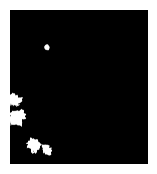

In [22]:
fp = BytesIO(row.leaf_mask)
x = np.load(fp)
print(x.shape, x.dtype, x.min(), x.max())
plt.figure(figsize=(2, 2))
plt.imshow(x, cmap="gray")
plt.axis("off")
plt.show()

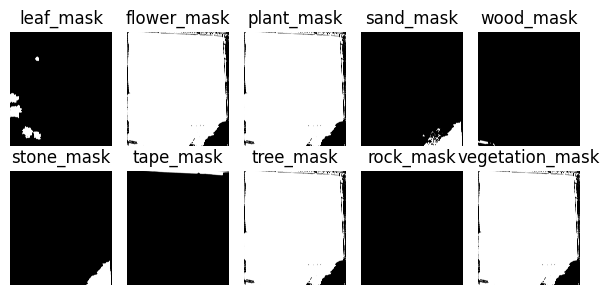

In [24]:
# we have two suplots
# the top is two columns, one with the original image and a table of data in 75/25 split
# the bottom is 2 rows of 5 columns containing all of the masks

fig, axs = plt.subplots(2, 5, figsize=(6, 3))
for (i, ax), col in zip(enumerate(axs.flatten()), mask_cols):
    fp = BytesIO(row[col])
    x = np.load(fp)
    ax.imshow(x, cmap="gray")
    ax.set_title(col)
    ax.axis("off")
plt.tight_layout()
plt.show()

In [25]:
# calculate the percentage of pixels
pdf = pd.DataFrame(
    [(col, np.mean(np.load(BytesIO(row[col])))) for col in mask_cols],
    columns=["mask", "percentage"],
)
pdf

,mask,percentage
0,leaf_mask,0.026535
1,flower_mask,0.918178
2,plant_mask,0.921702
3,sand_mask,0.037601
4,wood_mask,0.002308
5,stone_mask,0.029719
6,tape_mask,0.020369
7,tree_mask,0.921701
8,rock_mask,0.000000
9,vegetation_mask,0.920966


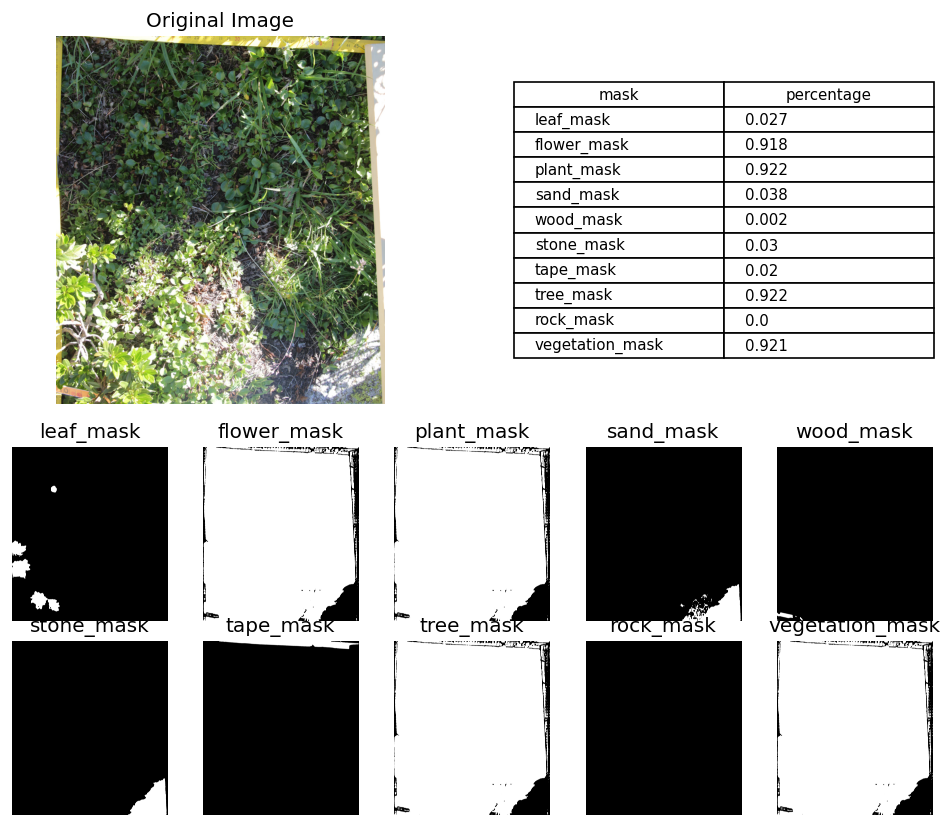

In [26]:
def plot_row(row, mask_cols):
    # Create figure with GridSpec layout
    # Top: image + table, Bottom: 2x5 masks
    fig = plt.figure(figsize=(8, 7), dpi=120)
    gs = fig.add_gridspec(2, 1, height_ratios=[1, 1])
    # Top section: Image and Table
    top_gs = gs[0].subgridspec(1, 2, width_ratios=[1, 1])

    # Load the original image
    img_fp = BytesIO(row["data"])  # Adjust column name accordingly
    img = Image.open(img_fp)

    # Left: Display original image
    ax_img = fig.add_subplot(top_gs[0, 0])
    ax_img.imshow(img)
    ax_img.set_title("Original Image")
    ax_img.axis("off")

    # Right: Display tabular information
    ax_table = fig.add_subplot(top_gs[0, 1])
    pdf = pd.DataFrame(
        [(col, np.mean(np.load(BytesIO(row[col])))) for col in mask_cols],
        columns=["mask", "percentage"],
    )
    # plot as a table using at most 3 decimal places
    ax_table.axis("off")
    ax_table.table(
        cellText=pdf.round(3).values,
        colLabels=pdf.columns,
        cellLoc="left",
        loc="center",
    )

    # Bottom section: 2x5 mask images
    bottom_gs = gs[1].subgridspec(2, 5)

    for i, (col, ax_pos) in enumerate(zip(mask_cols, bottom_gs)):
        fp = BytesIO(row[col])
        x = np.load(fp)

        ax = fig.add_subplot(ax_pos)
        ax.imshow(x, cmap="gray")
        ax.set_title(col)
        ax.axis("off")

    # Adjust layout and display
    plt.tight_layout()
    return fig


plot_row(row, mask_cols)
plt.show()

In [ ]:
# save a bunch of thse masks to scratch so we can evaluate them
p = Path("~/scratch/plantclef/mask_images").expanduser()
p.mkdir(exist_ok=True, parents=True)
for row in mask_image_df.limit(20).collect():
    fig = plot_row(row, mask_cols)
    output_path = f"{p}/{row.image_name}"
    print(f"Saving {output_path}")
    plt.savefig(output_path)
    plt.close(fig)

Saving /storage/home/hcoda1/8/amiyaguchi3/scratch/plantclef/mask_images/CBN-PdlC-A5-20130903.jpg
Saving /storage/home/hcoda1/8/amiyaguchi3/scratch/plantclef/mask_images/RNNB-7-6-20240118.jpg
Saving /storage/home/hcoda1/8/amiyaguchi3/scratch/plantclef/mask_images/CBN-Pla-D5-20160707.jpg
Saving /storage/home/hcoda1/8/amiyaguchi3/scratch/plantclef/mask_images/CBN-PdlC-A3-20180815.jpg
Saving /storage/home/hcoda1/8/amiyaguchi3/scratch/plantclef/mask_images/CBN-PdlC-B2-20160726.jpg
Saving /storage/home/hcoda1/8/amiyaguchi3/scratch/plantclef/mask_images/RNNB-1-3-20230512.jpg
Saving /storage/home/hcoda1/8/amiyaguchi3/scratch/plantclef/mask_images/CBN-Pla-F5-20200814.jpg
Saving /storage/home/hcoda1/8/amiyaguchi3/scratch/plantclef/mask_images/CBN-Pla-E2-20160707.jpg
Saving /storage/home/hcoda1/8/amiyaguchi3/scratch/plantclef/mask_images/CBN-PdlC-C6-20130903.jpg
Saving /storage/home/hcoda1/8/amiyaguchi3/scratch/plantclef/mask_images/CBN-PdlC-B6-20150810.jpg
Saving /storage/home/hcoda1/8/amiyaguch